In [2]:
import pandas as pd
import os
import sys
import numpy as np
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pickle
import scipy.stats as st

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tqdm.autonotebook import tqdm
from tqdm import trange

In [3]:
tf.__version__

'2.1.0'

In [4]:
%matplotlib inline

In [5]:
%load_ext autoreload

%autoreload 2

In [6]:
if os.getcwd().endswith("notebooks"):
    os.chdir(os.pardir)

In [7]:
sys.path.append(os.getcwd())

In [8]:
from src.data.train_data_utils import prepare_experiment, crossval_generator, prepare_crossval_experiment
from src.models.training_utils import generator_ratings, generator_ratings_features, mae_masked, mape_masked, mse_masked
from src.models.train_model import get_collabfiltering_model1, build_shallow_autorec_single_input, build_autorec_multi_input2, get_array

# Data prep

In [9]:
full_experiment_data, encoders = prepare_experiment()

{'rating', 'timestamp', 'split', 'item_id', 'user_id'}
Dtype: DataType.TRAIN shape: 36532
Dtype: DataType.TEST shape: 21952
Dtype: DataType.VALID shape: 14697
N train ids: 10167
N train val ids: 10168


In [10]:
test_joined = full_experiment_data.Xraw_test.merge(full_experiment_data.Xhidden_test, on=['user_id', 'item_id'], how='inner')
test_joined.head(3)

,user_id,item_id,rating_x,rating_y
0,0,0,2.0,2.0
1,13,24,5.0,0.0
2,24,30,5.0,5.0


In [11]:
ytest = np.expand_dims(full_experiment_data.Xraw_test.rating.to_numpy(), axis=1)

In [12]:
crossvals, encoders = prepare_crossval_experiment(nsplits=10)

{'rating', 'timestamp', 'split', 'item_id', 'user_id'}


C:\Users\fwojcik\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Processing cv 0
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 64083
Dtype: DataType.TEST shape: 5454
Dtype: DataType.VALID shape: 3644
N train ids: 18301
N train val ids: 2034
Processing cv 1
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 65267
Dtype: DataType.TEST shape: 4732
Dtype: DataType.VALID shape: 3182
N train ids: 18301
N train val ids: 2034
Processing cv 2
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 65928
Dtype: DataType.TEST shape: 4350
Dtype: DataType.VALID shape: 2903
N train ids: 18301
N train val ids: 2034
Processing cv 3
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 65835
Dtype: DataType.TEST shape: 4353
Dtype: DataType.VALID shape: 2993
N train ids: 18301
N train val ids: 2034
Processing cv 4
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 66018
Dtype: DataType.TEST shape: 4293
Dtype: DataType.VALID shape: 2870
N train ids: 18301
N 

In [13]:
import pickle

pickle.dump(crossvals, open("crossval_data.h", "wb"))

# Model prep

In [14]:
def huber_masked(y_true, y_pred):
    huber = tf.keras.losses.Huber()

    mask = y_true > 0.0
    
    return huber(y_true[mask], y_pred[mask])

In [15]:
def prepare_model_data_colab(exd):
    x = [
        exd.Xraw_train.user_id.to_numpy(),
        exd.Xraw_train.item_id.to_numpy(),
        exd.Xfeatures_train
    ]
    y = exd.Xraw_train.rating.to_numpy()

    x_val = [
        exd.Xraw_valid.user_id.to_numpy(),
        exd.Xraw_valid.item_id.to_numpy(),
        exd.Xfeatures_valid
    ]
    y_val = exd.Xraw_valid.rating.to_numpy()
    
    x_test = [
        exd.Xraw_test.user_id.to_numpy(dtype='int32'),
        exd.Xraw_test.item_id.to_numpy(dtype='int32')
    ]
    return x, y, x_val, y_val, x_test

In [45]:
exd.Xfeatures_valid.shape

(3644, 5)

In [50]:
exd.feature_names

['user_attr', 'model_attr', 'brand', 'category', 'year']

In [ ]:
exd.Xfeatures_test

In [52]:
def preapre_model_data_autorec(exd):
    x = [
        exd.Xraw_train.user_id.to_numpy(),
        exd.Xraw_train.item_id.to_numpy(),
        exd.Xfeatures_train[:, 0].astype('int32'),
        exd.Xfeatures_train[:, 1].astype('int32'),
        exd.Xfeatures_train[:, 2].astype('int32'),
        exd.Xfeatures_train[:, 3].astype('int32'),
    ]
    y = exd.Xraw_train.rating.to_numpy()

    x_val = [
        exd.Xraw_valid.user_id.to_numpy(),
        exd.Xraw_valid.item_id.to_numpy(),
        exd.Xfeatures_valid[:, 0].astype('int32'),
        exd.Xfeatures_valid[:, 1].astype('int32'),
        exd.Xfeatures_valid[:, 2].astype('int32'),
        exd.Xfeatures_valid[:, 3].astype('int32'),
    ]
    y_val = exd.Xraw_valid.rating.to_numpy()
    
    
    # TODO: investigat emissing enties in matrices below - why there are so many nan's
    x_test_reconstruction = [
        exd.Xhidden_test.user_id.to_numpy(dtype='int32'),
        exd.Xhidden_test.item_id.to_numpy(dtype='int32'),
        exd.Xfeatures_test[:, 0].astype('int32'),
        exd.Xfeatures_test[:, 1].astype('int32'),
        exd.Xfeatures_test[:, 2].astype('int32'),
        exd.Xfeatures_test[:, 3].astype('int32'),
    ]
    y_test_reconstruction = exd.Xhidden_test.rating
    
    x_test_pred = [
        exd.test_records_selected.user_id.to_numpy(dtype='int32'),
        exd.test_records_selected.item_id.to_numpy(dtype='int32'),
        exd.test_records_selected.iloc[:, :-5].to_numpy(dtype='int32')
    ]
    
    return x, y, x_val, y_val, x_test_reconstruction

In [17]:
exd = crossvals[0]

In [18]:
nulls = []
for exd in crossvals:
    null_i = exd.test_records_selected.iloc[:, :-5].isna().sum(axis=0).any()
    nulls.append(null_i)
nulls

[False, False, False, False, False, False, False, False, False, False]

In [19]:
def conduct_experiment(exd, model_building_func, data_prep_func, **kwargs):
    model = model_building_func(exd, **kwargs['build_params'])
    x, y, x_val, y_val, x_test = data_prep_func(exd)
    model_history = model.fit(x=x, y=y, validation_data=(x_val, y_val), **kwargs['fit_params'])
    
    ytest = np.expand_dims(exd.Xraw_test.rating.to_numpy(), axis=1)
    yhat = model.predict(x=x_test)
    mape = mape_masked(ytest, yhat).numpy()
    mse = mse_masked(ytest, yhat).numpy()
    return model, mape, mse, model_history

## Collaborative filtering with bias

In [20]:
def build_colab_filtering_model(exd, dim_embed=30):
    nusers = int(max(exd.Xraw_train.user_id.max(), exd.Xraw_test.user_id.max(), exd.Xraw_valid.user_id.max()))
    nitems = int(exd.Xraw_train.item_id.max())

    user_input = krs.Input(shape=(1,), name="user_input", dtype='int32')
    u = krs.layers.Embedding(nusers + 1, int(dim_embed))(user_input)
    u = krs.layers.Flatten()(u)
    u_bias = tf.keras.layers.Flatten()(krs.layers.Embedding(nusers + 1, 1)(user_input))

    item_input = krs.Input(shape=(1,), name='item_input', dtype='int32')
    i = krs.layers.Embedding(nitems + 1, int(dim_embed))(item_input)
    i = krs.layers.Flatten()(i)
    i_bias = krs.layers.Flatten()(krs.layers.Embedding(nitems + 1, 1)(item_input))

    ui = krs.layers.Dot(axes=(1,1))([u, i])

    all_features = krs.layers.Concatenate()([ui, u_bias, i_bias])
    drop1 = krs.layers.Dropout(0.4)(all_features)
    out = krs.layers.Dense(1)(drop1)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    model_mf = krs.Model(inputs=[user_input, item_input], outputs=out)
    model_mf.compile(loss=mse_masked, optimizer=optimizer, metrics=[mse_masked, 'mae', mape_masked])
    return model_mf

In [32]:
colab_mse = []
colab_mape = []

for exd in crossvals:
    colab_filtering_model, mape, mse, cf_history = conduct_experiment(exd, build_colab_filtering_model, prepare_model_data_colab, build_params={'dim_embed': 30}, fit_params={'batch_size': 32, 'epochs': 15})
    colab_mse.append(mse)
    colab_mape.append(mape)
    
    print(f"MSE: {colab_mse}")
    print(f"Mape: {colab_mape}")
    gc.collect()

Train on 64083 samples, validate on 3644 samples
Epoch 1/15
64083/64083 [==============================] - 12s 188us/sample - loss: 2.7959 - mse_masked: 2.7955 - mae: 1.2756 - mape_masked: 0.4327 - val_loss: 1.4413 - val_mse_masked: 1.4418 - val_mae: 0.9269 - val_mape_masked: 0.4105
Epoch 2/15
64083/64083 [==============================] - 11s 168us/sample - loss: 1.2329 - mse_masked: 1.2329 - mae: 0.8386 - mape_masked: 0.3572 - val_loss: 1.4097 - val_mse_masked: 1.4103 - val_mae: 0.9224 - val_mape_masked: 0.4026
Epoch 3/15
64083/64083 [==============================] - 11s 167us/sample - loss: 0.9690 - mse_masked: 0.9692 - mae: 0.7316 - mape_masked: 0.3036 - val_loss: 1.4089 - val_mse_masked: 1.4094 - val_mae: 0.9365 - val_mape_masked: 0.3997
Epoch 4/15
64083/64083 [==============================] - 11s 168us/sample - loss: 0.8195 - mse_masked: 0.8195 - mae: 0.6736 - mape_masked: 0.2702 - val_loss: 1.4224 - val_mse_masked: 1.4229 - val_mae: 0.9369 - val_mape_masked: 0.4016
Epoch 5/15


In [33]:
colab_res = pd.DataFrame({'colab_mse': colab_mse, 'colab_mape': colab_mape})
colab_res.to_csv("./notebooks/colab_res.csv", index=False)

In [79]:
colab_res = pd.read_csv("./notebooks/colab_res.csv", index_col=None)

In [80]:
colab_res

,colab_mse,colab_mape
0,1.341046,0.381724
1,1.451853,0.417127
2,1.405102,0.398994
3,1.407544,0.395755
4,1.268155,0.358347
5,1.203991,0.343120
6,1.395020,0.387410
7,1.440887,0.404051
8,1.447349,0.405730
9,1.412892,0.401230


## Deep recommender

In [48]:
exd.Xraw_train.head(3)

,user_id,item_id,rating
0,0,0,2.0
1,1,0,2.0
2,2,0,5.0


In [50]:
exd.Xfeatures_train.shape

(66618, 5)

In [31]:
20 ** (-4)

6.25e-06

In [34]:
for k, e in encoders.items():
    print(f"{k}: {e.classes_.shape[0]}")

user_attr: 3
model_attr: 3
brand: 51
category: 10
year: 20


In [53]:
def autorec_multiple_embeddings(exd, loss=mse_masked, optimizer='adam', metrics=[mse_masked, 'mae', mape_masked], *args, **kwargs):
    min_rating = min(exd.Xraw_train.rating.min(), exd.Xraw_valid.rating.min())
    max_rating = max(exd.Xraw_train.rating.max(), exd.Xraw_valid.rating.max())
    
    dim_embed = 30
    dim_embed_userattr = 2
    dim_embed_modelattr = 2
    dim_embed_brand = 10
    dim_embed_category = 2
    dim_embed_year = 4
    
    nusers = int(max(exd.Xraw_train.user_id.max(), exd.Xraw_test.user_id.max(), exd.Xraw_valid.user_id.max()))
    nitems = int(exd.Xraw_train.item_id.max())
    
    user_input = krs.Input(shape=(1,), name="user_input", dtype='int32')
    u = krs.layers.Embedding(nusers + 1, dim_embed, embeddings_initializer='he_normal')(user_input)
    u = krs.layers.Flatten()(u)
    u_bias = tf.keras.layers.Flatten()(krs.layers.Embedding(nusers + 1, 1, embeddings_initializer='he_normal',)(user_input))

    item_input = krs.Input(shape=(1,), name='item_input', dtype='int32')
    i = krs.layers.Embedding(nitems + 1, dim_embed, embeddings_initializer='he_normal',)(item_input)
    i = krs.layers.Flatten()(i)
    i_bias = krs.layers.Flatten()(krs.layers.Embedding(nitems + 1, 1, embeddings_initializer='he_normal',)(item_input))
    
    uattr_input = krs.Input(shape=(1, ), name='userattr_input', dtype='int32')
    uattr = krs.layers.Embedding(4, dim_embed_userattr, embeddings_initializer='he_normal',)(uattr_input)
    uattr = krs.layers.Flatten()(uattr)
    
    mattr_input = krs.Input(shape=(1, ), name='modelattr_input', dtype='int32')
    mattr = krs.layers.Embedding(4, dim_embed_modelattr, embeddings_initializer='he_normal',)(mattr_input)
    mattr = krs.layers.Flatten()(mattr)
    
    brand_input = krs.Input(shape=(1, ), name='brand_input', dtype='int32')
    br = krs.layers.Embedding(52, dim_embed_brand, embeddings_initializer='he_normal',)(brand_input)
    br = krs.layers.Flatten()(br)
    
    cat_input = krs.Input(shape=(1, ), name='cat_input', dtype='int32')
    cat =  krs.layers.Embedding(11, dim_embed_category, embeddings_initializer='he_normal',)(cat_input)
    cat = krs.layers.Flatten()(cat)
    
    all_features = krs.layers.Concatenate(axis=1)([u, u_bias, i, i_bias, uattr, mattr, br, cat])
    drop =  krs.layers.Dropout(rate=0.2)(all_features)
    d1 = krs.layers.Dense(16, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l1(1e-4))(drop) #,  kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(all_features)
    drop2 = krs.layers.Dropout(rate=0.2)(d1)
    d2 = krs.layers.Dense(8, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l1(1e-4))(drop2) #,  kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(d1)
    out = krs.layers.Dense(1, activation='sigmoid')(d2)
    out = krs.layers.Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(out)

    model = krs.Model(inputs=[user_input, item_input, uattr_input, mattr_input, brand_input, cat_input], outputs=out, *args, **kwargs)

    model.compile(loss=mse_masked, optimizer=optimizer, metrics=metrics)
    print(model.summary())
    return model

In [67]:
def build_autorec_model(exd, loss=mse_masked, optimizer='adam', metrics=[mse_masked, 'mae', mape_masked], *args, **kwargs):
    min_rating = min(exd.Xraw_train.rating.min(), exd.Xraw_valid.rating.min())
    max_rating = max(exd.Xraw_train.rating.max(), exd.Xraw_valid.rating.max())
    #dim_embed = 30
    dim_embed = 30
    nusers = int(max(exd.Xraw_train.user_id.max(), exd.Xraw_test.user_id.max(), exd.Xraw_valid.user_id.max()))
    nitems = int(exd.Xraw_train.item_id.max())

    f_input = krs.Input(shape=(exd.Xfeatures_train.shape[1],), name="features_input", dtype='float32')
    f_drop = krs.layers.Dropout(rate=0.1)(f_input)
    f_dense = krs.layers.Dense(32, activation='relu', kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l1(1e-4))(f_drop) #, kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(f_input)
    #f_drop2 = krs.layers.Dropout(rate=0.3)(f_dense)
    #f_dense2 = krs.layers.Dense(16, activation="relu", kernel_initializer=krs.initializers.GlorotNormal())(f_drop2)


    user_input = krs.Input(shape=(1,), name="user_input", dtype='int32')
    u = krs.layers.Embedding(nusers + 1, dim_embed, embeddings_initializer='he_normal')(user_input)
    u = krs.layers.Flatten()(u)
    u_bias = tf.keras.layers.Flatten()(krs.layers.Embedding(nusers + 1, 1, embeddings_initializer='he_normal',)(user_input))

    item_input = krs.Input(shape=(1,), name='item_input', dtype='int32')
    i = krs.layers.Embedding(nitems + 1, dim_embed, embeddings_initializer='he_normal',)(item_input)
    i = krs.layers.Flatten()(i)
    i_bias = krs.layers.Flatten()(krs.layers.Embedding(nitems + 1, 1, embeddings_initializer='he_normal',)(item_input))

    ui = krs.layers.Dot(axes=(1,1))([u, i])
    #ui = krs.layers.Multiply()([u, i])

    #all_features = krs.layers.Concatenate(axis=1)([ui, f_dense, u_bias, i_bias])
    all_features = krs.layers.Concatenate(axis=1)([ui, u_bias, i_bias, f_dense])
    drop =  krs.layers.Dropout(rate=0.2)(all_features)
    
    d1 = krs.layers.Dense(16, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l1(1e-4))(drop) #,  kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(all_features)
    drop2 = krs.layers.Dropout(rate=0.2)(d1) 
    
    d2 = krs.layers.Dense(8, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l1(1e-4))(drop2) #,  kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(d1)
    out = krs.layers.Dense(1, activation='sigmoid')(d2)
    out = krs.layers.Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(out)

    model = krs.Model(inputs=[user_input, item_input, f_input], outputs=out, *args, **kwargs)

    model.compile(loss=mse_masked, optimizer=optimizer, metrics=metrics)
    print(model.summary())
    return model

### Learning rate pre-selection for deep autorec model

Perform learning rate pre-selection using single cross-validation fold.

In [56]:
preselect_exd = crossvals[0]

In [66]:
krs.backend.clear_session()

In [67]:
import gc
gc.collect()

49141

In [68]:
initial_lr = 0.001
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=initial_lr, momentum=0.9)
build_params = {
    'optimizer': optimizer,
    'loss': huber_masked,
    'metrics': [mse_masked, mape_masked, 'mae']
}

_, mape, mse, autorec_history = conduct_experiment(exd, autorec_multiple_embeddings, preapre_model_data_autorec, build_params=build_params, fit_params={'batch_size': 16, 'epochs': 15, 'callbacks': [lr_schedule]})

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
userattr_input (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
modelattr_input (InputLayer)    [(None, 1)]          0                                            
______________________________________________________________________________________________

64083/64083 [==============================] - 11s 165us/sample - loss: 1.3746 - mse_masked: 1.3592 - mape_masked: 0.3862 - mae: 0.9005 - val_loss: 1.4639 - val_mse_masked: 1.4487 - val_mape_masked: 0.4110 - val_mae: 0.9209
Epoch 7/15
64083/64083 [==============================] - 11s 171us/sample - loss: 1.3456 - mse_masked: 1.3300 - mape_masked: 0.3795 - mae: 0.8843 - val_loss: 1.4364 - val_mse_masked: 1.4212 - val_mape_masked: 0.4066 - val_mae: 0.9086
Epoch 8/15
64083/64083 [==============================] - 13s 199us/sample - loss: 1.2915 - mse_masked: 1.2758 - mape_masked: 0.3676 - mae: 0.8619 - val_loss: 1.4602 - val_mse_masked: 1.4447 - val_mape_masked: 0.4126 - val_mae: 0.8971
Epoch 9/15
64083/64083 [==============================] - 12s 182us/sample - loss: 1.1171 - mse_masked: 1.1004 - mape_masked: 0.3268 - mae: 0.7787 - val_loss: 1.5164 - val_mse_masked: 1.4994 - val_mape_masked: 0.4202 - val_mae: 0.8970
Epoch 10/15
64083/64083 [==============================] - 11s 171us/sa

In [69]:
autorec_history.history.keys()

dict_keys(['loss', 'mse_masked', 'mape_masked', 'mae', 'val_loss', 'val_mse_masked', 'val_mape_masked', 'val_mae', 'lr'])

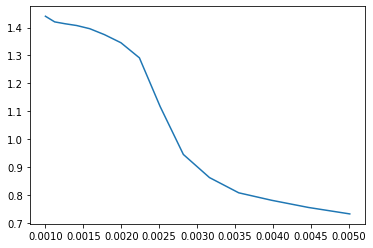

In [70]:
plt.plot(autorec_history.history['lr'], autorec_history.history['loss'])

Optimal learning rate seems to be approx.: 0.012

In [72]:
lr = 0.005

### Deep autorec crossval

In [73]:
import gc
tf.keras.backend.clear_session()
gc.collect()

autorec_mse = []
autorec_mape = []
es = krs.callbacks.EarlyStopping(monitor='val_mape_masked', mode='min', min_delta=0.002, patience=3)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr) #tf.keras.optimizers.SGD(lr=lr, momentum=0.9)
build_params = {
    'optimizer': optimizer,
    'loss': huber_masked,
    'metrics': [mse_masked, mape_masked, 'mae']
}
    
for exd in crossvals:
    autorec_model, mape, mse, autorec_history = conduct_experiment(exd, autorec_multiple_embeddings, preapre_model_data_autorec, build_params=build_params, fit_params={'batch_size': 16, 'epochs': 15, 'callbacks': [es]})
    autorec_mse.append(mse)
    autorec_mape.append(mape)
    
    print(f"MSE: {autorec_mse}")
    print(f"Mape: {autorec_mape}")
    gc.collect()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
userattr_input (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
modelattr_input (InputLayer)    [(None, 1)]          0                                            
______________________________________________________________________________________________

64083/64083 [==============================] - 55s 863us/sample - loss: 0.7502 - mse_masked: 0.7310 - mape_masked: 0.2319 - mae: 0.5507 - val_loss: 1.5811 - val_mse_masked: 1.5624 - val_mape_masked: 0.3871 - val_mae: 1.0497
Epoch 6/15
64083/64083 [==============================] - 48s 751us/sample - loss: 0.7013 - mse_masked: 0.6817 - mape_masked: 0.2183 - mae: 0.5230 - val_loss: 1.6459 - val_mse_masked: 1.6268 - val_mape_masked: 0.3903 - val_mae: 1.0871
Epoch 7/15
64083/64083 [==============================] - 55s 865us/sample - loss: 0.6709 - mse_masked: 0.6510 - mape_masked: 0.2102 - mae: 0.5040 - val_loss: 1.7407 - val_mse_masked: 1.7204 - val_mape_masked: 0.3925 - val_mae: 1.1221
Epoch 8/15
64083/64083 [==============================] - 51s 799us/sample - loss: 0.6308 - mse_masked: 0.6106 - mape_masked: 0.1995 - mae: 0.4800 - val_loss: 1.7503 - val_mse_masked: 1.7292 - val_mape_masked: 0.3915 - val_mae: 1.1244
MSE: [1.7200897]
Mape: [0.3773876]
Model: "model_1"
___________________

65267/65267 [==============================] - 83s 1ms/sample - loss: 1.3300 - mse_masked: 1.3153 - mape_masked: 0.3741 - mae: 0.8713 - val_loss: 1.4410 - val_mse_masked: 1.4286 - val_mape_masked: 0.4040 - val_mae: 0.9648
Epoch 2/15
65267/65267 [==============================] - 67s 1ms/sample - loss: 1.0283 - mse_masked: 1.0136 - mape_masked: 0.3063 - mae: 0.7021 - val_loss: 1.4702 - val_mse_masked: 1.4564 - val_mape_masked: 0.3987 - val_mae: 0.9953
Epoch 3/15
65267/65267 [==============================] - 49s 747us/sample - loss: 0.9144 - mse_masked: 0.8996 - mape_masked: 0.2790 - mae: 0.6430 - val_loss: 1.5660 - val_mse_masked: 1.5519 - val_mape_masked: 0.3975 - val_mae: 1.0531
Epoch 4/15
65267/65267 [==============================] - 44s 667us/sample - loss: 0.8551 - mse_masked: 0.8402 - mape_masked: 0.2634 - mae: 0.6087 - val_loss: 1.6552 - val_mse_masked: 1.6408 - val_mape_masked: 0.3978 - val_mae: 1.1021
Epoch 5/15
65267/65267 [==============================] - 41s 629us/sample 

65928/65928 [==============================] - 52s 786us/sample - loss: 1.3394 - mse_masked: 1.3242 - mape_masked: 0.3761 - mae: 0.8759 - val_loss: 1.3758 - val_mse_masked: 1.3624 - val_mape_masked: 0.3808 - val_mae: 0.9209
Epoch 2/15
65928/65928 [==============================] - 61s 918us/sample - loss: 1.0201 - mse_masked: 1.0039 - mape_masked: 0.3047 - mae: 0.7048 - val_loss: 1.4379 - val_mse_masked: 1.4238 - val_mape_masked: 0.3795 - val_mae: 0.9876
Epoch 3/15
65928/65928 [==============================] - 60s 917us/sample - loss: 0.8916 - mse_masked: 0.8745 - mape_masked: 0.2719 - mae: 0.6349 - val_loss: 1.5512 - val_mse_masked: 1.5360 - val_mape_masked: 0.3804 - val_mae: 1.0490
Epoch 4/15
65928/65928 [==============================] - 81s 1ms/sample - loss: 0.8217 - mse_masked: 0.8035 - mape_masked: 0.2525 - mae: 0.5935 - val_loss: 1.5591 - val_mse_masked: 1.5425 - val_mape_masked: 0.3799 - val_mae: 1.0200
MSE: [1.7200897, 1.7180241, 1.539497]
Mape: [0.3773876, 0.3957509, 0.3841

65835/65835 [==============================] - 61s 924us/sample - loss: 1.3439 - mse_masked: 1.3293 - mape_masked: 0.3781 - mae: 0.8784 - val_loss: 1.2249 - val_mse_masked: 1.2078 - val_mape_masked: 0.3377 - val_mae: 0.8651
Epoch 2/15
65835/65835 [==============================] - 63s 956us/sample - loss: 1.0323 - mse_masked: 1.0161 - mape_masked: 0.3085 - mae: 0.7114 - val_loss: 1.3977 - val_mse_masked: 1.3789 - val_mape_masked: 0.3411 - val_mae: 0.9848
Epoch 3/15
65835/65835 [==============================] - 61s 925us/sample - loss: 0.9203 - mse_masked: 0.9028 - mape_masked: 0.2809 - mae: 0.6509 - val_loss: 1.3791 - val_mse_masked: 1.3588 - val_mape_masked: 0.3393 - val_mae: 0.9647
Epoch 4/15
65835/65835 [==============================] - 66s 1ms/sample - loss: 0.8688 - mse_masked: 0.8512 - mape_masked: 0.2681 - mae: 0.6225 - val_loss: 1.5776 - val_mse_masked: 1.5585 - val_mape_masked: 0.3508 - val_mae: 1.0881
MSE: [1.7200897, 1.7180241, 1.539497, 1.6479102]
Mape: [0.3773876, 0.3957

66018/66018 [==============================] - 60s 916us/sample - loss: 1.3521 - mse_masked: 1.3380 - mape_masked: 0.3802 - mae: 0.8838 - val_loss: 1.3467 - val_mse_masked: 1.3367 - val_mape_masked: 0.3739 - val_mae: 0.9230
Epoch 2/15
66018/66018 [==============================] - 50s 758us/sample - loss: 1.0603 - mse_masked: 1.0455 - mape_masked: 0.3153 - mae: 0.7211 - val_loss: 1.4898 - val_mse_masked: 1.4778 - val_mape_masked: 0.3766 - val_mae: 1.0422
Epoch 3/15
66018/66018 [==============================] - 54s 815us/sample - loss: 0.9439 - mse_masked: 0.9282 - mape_masked: 0.2868 - mae: 0.6575 - val_loss: 1.5730 - val_mse_masked: 1.5589 - val_mape_masked: 0.3754 - val_mae: 1.0677- mae: 
Epoch 4/15
66018/66018 [==============================] - 60s 914us/sample - loss: 0.8828 - mse_masked: 0.8665 - mape_masked: 0.2712 - mae: 0.6239 - val_loss: 1.7531 - val_mse_masked: 1.7377 - val_mape_masked: 0.3810 - val_mae: 1.1500
MSE: [1.7200897, 1.7180241, 1.539497, 1.6479102, 1.676551]
Mape:

66100/66100 [==============================] - 66s 995us/sample - loss: 1.3604 - mse_masked: 1.3464 - mape_masked: 0.3831 - mae: 0.8897 - val_loss: 1.2407 - val_mse_masked: 1.2287 - val_mape_masked: 0.3408 - val_mae: 0.8986
Epoch 2/15
66100/66100 [==============================] - 56s 844us/sample - loss: 1.0576 - mse_masked: 1.0414 - mape_masked: 0.3155 - mae: 0.7232 - val_loss: 1.2514 - val_mse_masked: 1.2375 - val_mape_masked: 0.3400 - val_mae: 0.8836
Epoch 3/15
66100/66100 [==============================] - 50s 753us/sample - loss: 0.9420 - mse_masked: 0.9260 - mape_masked: 0.2872 - mae: 0.6617 - val_loss: 1.4486 - val_mse_masked: 1.4341 - val_mape_masked: 0.3483 - val_mae: 1.0130
Epoch 4/15
66100/66100 [==============================] - 47s 713us/sample - loss: 0.8693 - mse_masked: 0.8525 - mape_masked: 0.2682 - mae: 0.6233 - val_loss: 1.4779 - val_mse_masked: 1.4626 - val_mape_masked: 0.3475 - val_mae: 1.0232
MSE: [1.7200897, 1.7180241, 1.539497, 1.6479102, 1.676551, 1.4387277]
M

66100/66100 [==============================] - 57s 858us/sample - loss: 1.3440 - mse_masked: 1.3313 - mape_masked: 0.3792 - mae: 0.8808 - val_loss: 1.2788 - val_mse_masked: 1.2641 - val_mape_masked: 0.3473 - val_mae: 0.902973 - ms - E
Epoch 2/15
66100/66100 [==============================] - 60s 910us/sample - loss: 1.0401 - mse_masked: 1.0260 - mape_masked: 0.3107 - mae: 0.7131 - val_loss: 1.5779 - val_mse_masked: 1.5616 - val_mape_masked: 0.3576 - val_mae: 1.0947
Epoch 3/15
66100/66100 [==============================] - 56s 849us/sample - loss: 0.9325 - mse_masked: 0.9185 - mape_masked: 0.2847 - mae: 0.6577 - val_loss: 1.4694 - val_mse_masked: 1.4529 - val_mape_masked: 0.3467 - val_mae: 1.0077
Epoch 4/15
66100/66100 [==============================] - 59s 890us/sample - loss: 0.8709 - mse_masked: 0.8567 - mape_masked: 0.2696 - mae: 0.6251 - val_loss: 1.6496 - val_mse_masked: 1.6317 - val_mape_masked: 0.3552 - val_mae: 1.1006
MSE: [1.7200897, 1.7180241, 1.539497, 1.6479102, 1.676551, 1

66272/66272 [==============================] - 60s 912us/sample - loss: 1.3367 - mse_masked: 1.3234 - mape_masked: 0.3754 - mae: 0.8746 - val_loss: 1.5218 - val_mse_masked: 1.5061 - val_mape_masked: 0.4211 - val_mae: 0.9955
Epoch 2/15
66272/66272 [==============================] - 59s 884us/sample - loss: 1.0470 - mse_masked: 1.0337 - mape_masked: 0.3109 - mae: 0.7163 - val_loss: 1.6069 - val_mse_masked: 1.5906 - val_mape_masked: 0.4175 - val_mae: 1.0733
Epoch 3/15
66272/66272 [==============================] - 62s 933us/sample - loss: 0.9045 - mse_masked: 0.8905 - mape_masked: 0.2744 - mae: 0.6405 - val_loss: 1.6570 - val_mse_masked: 1.6399 - val_mape_masked: 0.4158 - val_mae: 1.0968
Epoch 4/15
66272/66272 [==============================] - 66s 998us/sample - loss: 0.8279 - mse_masked: 0.8135 - mape_masked: 0.2540 - mae: 0.5950 - val_loss: 1.6979 - val_mse_masked: 1.6785 - val_mape_masked: 0.4130 - val_mae: 1.0866
Epoch 5/15
66272/66272 [==============================] - 61s 915us/sam

66408/66408 [==============================] - 81s 1ms/sample - loss: 1.3342 - mse_masked: 1.3185 - mape_masked: 0.3753 - mae: 0.8759 - val_loss: 1.4160 - val_mse_masked: 1.4020 - val_mape_masked: 0.3910 - val_mae: 0.9579
Epoch 2/15
66408/66408 [==============================] - 60s 911us/sample - loss: 1.0238 - mse_masked: 1.0060 - mape_masked: 0.3054 - mae: 0.7081 - val_loss: 1.4943 - val_mse_masked: 1.4766 - val_mape_masked: 0.3889 - val_mae: 1.0163
Epoch 3/15
66408/66408 [==============================] - 63s 945us/sample - loss: 0.8893 - mse_masked: 0.8698 - mape_masked: 0.2700 - mae: 0.6337 - val_loss: 1.5355 - val_mse_masked: 1.5161 - val_mape_masked: 0.3868 - val_mae: 1.0176
Epoch 4/15
66408/66408 [==============================] - 66s 997us/sample - loss: 0.8086 - mse_masked: 0.7880 - mape_masked: 0.2480 - mae: 0.5893 - val_loss: 1.6921 - val_mse_masked: 1.6715 - val_mape_masked: 0.3897 - val_mae: 1.1033
Epoch 5/15
66408/66408 [==============================] - 74s 1ms/sample 

66618/66618 [==============================] - 89s 1ms/sample - loss: 1.3468 - mse_masked: 1.3340 - mape_masked: 0.3782 - mae: 0.8804 - val_loss: 1.4003 - val_mse_masked: 1.3883 - val_mape_masked: 0.3748 - val_mae: 0.9858
Epoch 2/15
66618/66618 [==============================] - 80s 1ms/sample - loss: 1.0596 - mse_masked: 1.0460 - mape_masked: 0.3146 - mae: 0.7211 - val_loss: 1.4514 - val_mse_masked: 1.4370 - val_mape_masked: 0.3714 - val_mae: 0.9799.0211 - mse_masked: 1.0070 - mape_masked: 0.3063 - ma - ETA: 36s - loss: 1.0202 - mse_masked: 1.0061 - mape_maske - ETA: 35s - loss: - ETA: 31s - loss - ETA: 27s - loss: 1.0313 - mse_masked: 1.0 - ETA: 25s - loss: 1.0306 - mse_masked: 1.0167 - mape_m
Epoch 3/15
66618/66618 [==============================] - 71s 1ms/sample - loss: 0.9475 - mse_masked: 0.9341 - mape_masked: 0.2861 - mae: 0.6567 - val_loss: 1.4774 - val_mse_masked: 1.4632 - val_mape_masked: 0.3710 - val_mae: 0.9853
Epoch 4/15
66618/66618 [==============================] - 64s 

In [74]:
autorec_results = pd.DataFrame({
    'autorec_mape': autorec_mape,
    'autorec_mse': autorec_mse
})


In [75]:
autorec_results.to_csv("./notebooks/autorec_results.csv", index=False)

In [76]:
autorec_results = pd.read_csv("./notebooks/autorec_results.csv", index_col=None)

In [91]:
autorec_results

,autorec_mape,autorec_mse
0,0.377388,1.720090
1,0.395751,1.718024
2,0.384147,1.539497
3,0.390295,1.647910
4,0.361578,1.676551
5,0.339435,1.438728
6,0.386466,1.732537
7,0.400784,1.859382
8,0.399498,1.831212
9,0.393018,1.681269


In [92]:
colab_res

,colab_mse,colab_mape
0,1.341046,0.381724
1,1.451853,0.417127
2,1.405102,0.398994
3,1.407544,0.395755
4,1.268155,0.358347
5,1.203991,0.343120
6,1.395020,0.387410
7,1.440887,0.404051
8,1.447349,0.405730
9,1.412892,0.401230


In [78]:
autorec_results.describe()

,autorec_mape,autorec_mse
count,10.000000,10.000000
mean,0.382836,1.684520
std,0.019166,0.124565
min,0.339435,1.438728
25%,0.379078,1.655070
50%,0.388380,1.699646
75%,0.395068,1.729425
max,0.400784,1.859382


In [94]:
autorec_results.autorec_mse.mean(), colab_res.colab_mse.mean()

(1.6845198392868042, 1.3773839950561524)

# Compare two models

In [81]:
st.wilcoxon(autorec_results.autorec_mape, colab_res.colab_mape, correction=True, alternative='two-sided')

WilcoxonResult(statistic=2.0, pvalue=0.010826921277131306)

In [83]:
st.wilcoxon(autorec_results.autorec_mse, colab_res.colab_mse, correction=True)

WilcoxonResult(statistic=0.0, pvalue=0.005921537024148708)

In [84]:
st.mannwhitneyu(autorec_results.autorec_mse, colab_res.colab_mse, use_continuity=True)

MannwhitneyuResult(statistic=3.0, pvalue=0.00021981937631328227)

In [86]:
st.mannwhitneyu(autorec_results.autorec_mape, colab_res.colab_mape, use_continuity=False)

MannwhitneyuResult(statistic=34.0, pvalue=0.11323803302174312)

In [90]:
st.kruskal(autorec_results.autorec_mse, colab_res.colab_mse)

KruskalResult(statistic=12.622857142857143, pvalue=0.0003810584520506864)

In [87]:
st.ttest_ind(autorec_results.autorec_mse, colab_res.colab_mse, equal_var=False)

Ttest_indResult(statistic=6.504160376112249, pvalue=8.209933725459241e-06)

In [88]:
st.ttest_ind(autorec_results.autorec_mape, colab_res.colab_mape, equal_var=False)

Ttest_indResult(statistic=-0.6909034172275881, pvalue=0.49870164935874917)